In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
# cifar-10 데이터 로드
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [3]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [4]:
# 정규화하기
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [5]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

![resnet-architectures-34-101](https://user-images.githubusercontent.com/104133352/178133336-4ec8dd5b-27d4-491b-9897-d9873fe4ac98.png)

* ResNet을 설계해 보자  
   - 기본 형태만을 구현하여, 34 모델을 만들지 50 모델을 만들지는 모델 생성 시에 설정할 수 있도록 하자.
   - resnet과 plain의 구조는 'Deep Residual Learning for Image Recognition'논문의 figure3을 기준으로 재연하고자 하였다.
   - 

#시행착오  
1. 노드의 원문을 참고하여 input_shape=(7,7,3), num_cnn_list=[6,8,12,6], channel_list=[64,128,256,512], num_classes=10 의 값을 인자(argument)로서 전달하여 선언할 때 resnet-34인지 50인지를 설정하게 하려 했는데,
문제에서 주어진 상황은, resnet50을 기본으로 설계하여 50이 아닐 때를 is_50=false으로 만들라고 하고 있다.
build_resnet이 받는 인자는 오직 input_shape값이다.
2. 도저히 is_50 true/false으로 변경시키는 법을 모르겠다..
따로따로 resnet34,50,plain34,50을 구현해보자

* plain 34, 50 설계  
    plain을 설계해보자, class값은 우리가 다루는 데이터가 cifar-10의 클레스이므로 10이다.
    plain은 resnet에서 skip connection 구조가 없는 모델이니, 위의 그림 대로 블록을 동일하게 쌓는다.

In [24]:
############## build_plane net ##############
def build_plainnet(input_shape, num_classes, is_50):
    num_cnn_list = [3,4,6,3]
    channel_list = [64,128,256,512]

    # 50 일때 
    if is_50 :

        # 모델 돌리기 전에 config list 길이 확인
        assert len(num_cnn_list) == len(channel_list)
        
        ############ input layer 생성 ###########
        input_layer = keras.layers.Input(shape = input_shape, name = 'InputLayer')
        output = keras.layers.Conv2D(filters = channel_list[0],
                                    kernel_size = (1,1),
                                    strides = 2,
                                    kernel_initializer = 'he_normal',
                                    padding = 'same',
                                    name = 'conv2D_1st')(input_layer)
        output = keras.layers.BatchNormalization()(output)
        output = keras.layers.Activation('relu')(output)
        # maxpooling
        output = keras.layers.MaxPool2D(pool_size=(1, 1),
                                strides = 2)(output)

        ############ Block layer ##############
        #config list 길이만큼 반복해서 블록 생성 
        prev_channel = channel_list[0]
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            strides = 1 if channel == prev_channel else 2
            output = build_50_layer_block(output,
                                        num_cnn = num_cnn,
                                        channel = channel,
                                        strides = strides,
                                        block_num = i,
                                        is_residual = False)
            prev_channel = channel

    else:

        # 모델 돌리기 전에 config list 길이 확인
        assert len(num_cnn_list) == len(channel_list)

        ############ input layer 생성 ###########
        input_layer = keras.layers.Input(shape = input_shape, name = 'InputLayer')
        output = keras.layers.Conv2D(filters = channel_list[0],
                                    kernel_size = (1,1),
                                    strides = 2,
                                    kernel_initializer = 'he_normal',
                                    padding = 'same',
                                    name = 'conv2D_1st')(input_layer)
        output = keras.layers.BatchNormalization()(output)
        output = keras.layers.Activation('relu')(output)
        # maxpooling
        output = keras.layers.MaxPool2D(pool_size=(1, 1),
                                strides = 2)(output)

        ############ Block layer ##############
        prev_channel = channel_list[0]
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            strides = 1 if channel == prev_channel else 2
            output = build_34_layer_block(output,
                                        num_cnn = num_cnn,
                                        channel = channel,
                                        strides = strides,
                                        block_num = i,
                                        is_residual = False)
            prev_channel = channel

        
# Dense layer 생성 
    output = keras.layers.AveragePooling2D(pool_size=(1, 1),
                                           strides= 1,
                                           padding= 'same',
                                           name = 'Last_Pooling')(output)
    output = keras.layers.Flatten(name = 'Flatten')(output)
    output = keras.layers.Dense(num_classes, activation = 'sigmoid', name = 'predictions')(output)

# model 생성
    model = keras.Model(inputs = input_layer,
                        outputs = output)
    
    return model

In [25]:
plain_34 = build_plainnet(input_shape=(32, 32,3), num_classes = 10, is_50 =False)
plain_34.summary()

# tf.keras.utils.plot_model(plainnet_34, 'model.png', show_shapes = True)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2D_1st (Conv2D)          (None, 16, 16, 64)        256       
_________________________________________________________________
batch_normalization_229 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
activation_176 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_230 (Bat (None, 8, 8, 64)          256 

In [27]:
plain_50 = build_plainnet(input_shape=(32, 32,3), num_classes = 10, is_50 = True)
plain_50.summary()

# tf.keras.utils.plot_model(plainnet_50, 'model.png', show_shapes = True)

ValueError: Operands could not be broadcast together with shapes (2, 2, 512) (4, 4, 512)

### Resnet34

In [12]:
# ResNet 34 Block 만들기
def build_34_layer_block(input_layer,
                          num_cnn = 3,
                          channel = 64,
                          block_num = 1,
                          strides = 1,
                          is_residual = True):
    
    #입력 레이어
    x = input_layer

    #CNN 레이어
    for cnn_num in range(num_cnn):
        #identity mapping 설정
        identity_mapping = x
        ########### layer1 ##############
        # conv2D residual을 더해야하기때문에 padding = 'same'으로 맞춰줌
        x = keras.layers.Conv2D(filters = channel,
                                kernel_size = (3,3),
                                strides = strides,
                                kernel_initializer = 'he_normal',
                                padding = 'same',
                                name = f'block{block_num}_conv{cnn_num}'
                                )(x)
                                
        # conv2D 다음 Batch normalization
        x = keras.layers.BatchNormalization()(x)
        # BN 다음 activation(relu)
        x = keras.layers.Activation('relu')(x)

        ########### layer2 ##############
        # conv2D
        x = keras.layers.Conv2D(filters = channel,
                                strides = 1,
                                kernel_size = (3,3),
                                kernel_initializer = 'he_normal',
                                padding = 'same',
                                name = f'blcok{block_num}_conv{cnn_num}'
                                )(x)
        # conv2D 다음 Batch normalization
        x = keras.layers.BatchNormalization()(x)

        if is_residual:
            ########### skip connection #############
            if strides != 1 :
                # identity mapping conv 진행
                identity_mapping = keras.layers.Conv2D(filters = channel,
                                                    kernel_size = (1,1),
                                                    strides = 2)(identity_mapping)
                # conv2D 다음 Batch normalization
                identity_mapping = keras.layers.BatchNormalization()(identity_mapping)
                # 다음 스텝용 strides 변경
                srides = 1

           ########### Shortcut connection ##############
           #identity mapping 더해주는 레이어
            x = keras.layers.Add()([x, identity_mapping])
           # Add 후 activation(relu)

        x = keras.layers.Activation('relu')(x)


    return x

In [13]:
def build_resnet_34(input_shape=(32,32,3), num_cnn_list=[3,4,6,3], channel_list=[64,128,256,512], num_classes=10, is_resnet=True):
    # 안으로 집어넣어야 할 argument: num_cnn_list, channel_list, num_classes
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인
    
    input_layer = keras.layers.Input(shape = input_shape, name = 'InputLayer') # input layer 생성
    output = keras.layers.Conv2D(filters = channel_list[0],
                                 kernel_size = (1,1),
                                 strides = 2, 
                                 kernel_initializer='he_normal',
                                 padding='same',
                                 name='conv2D_1st')(input_layer)
        
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    # maxpooling
    output = keras.layers.MaxPool2D(pool_size=(1,1),
                                    strides=2)(output)
    
    ## convolution layer생성
    #config list 길이만큼 반복해서 블록 생성
    prev_channel = channel_list[0]
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        # 채널이 변할 때 stride 변화
        strides = 1 if channel == prev_channel else 2
        output = build_34_layer_block(output, num_cnn=num_cnn, channel=channel, strides=strides, block_num=i)
        prev_channel = channel
        
    output = keras.layers.AveragePooling2D(pool_size=(1,1),
                                           strides=1, padding='same', name='Last_Pooling')(output)
    output = keras.layers.Flatten(name='Flatten')(output)
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='predictions')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    
    return model

In [14]:
resnet_34 = build_resnet_34(input_shape=(32,32,3))
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputLayer (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2D_1st (Conv2D)             (None, 16, 16, 64)   256         InputLayer[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2D_1st[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### resnet50 만들기

In [15]:
# ResNet 50 Block 
def build_50_layer_block(input_layer,
                          num_cnn = 3,
                          channel = 64,
                          block_num = 1,
                          strides = 1,
                          is_residual = True):
    
    #입력 레이어
    x = input_layer
    identity_mapping = x
    identity_mapping = keras.layers.Conv2D(filters = (channel * 4),
                                                        kernel_size = (1,1),
                                                        padding = 'same',
                                                        strides = strides)(identity_mapping)
    identity_mapping = keras.layers.BatchNormalization()(identity_mapping)
    
    #CNN 레이어
    for cnn_num in range(num_cnn):
        ########### layer1 ##############
        # conv2D residual을 더해야하기때문에 padding = 'same'으로 맞춰줌
        x = keras.layers.Conv2D(filters = channel,
                                kernel_size = (1,1),
                                strides = strides,
                                kernel_initializer = 'he_normal',
                                padding = 'same',
                                name = f'block{block_num}_conv{cnn_num}_1x1_1st'
                                )(x)
                                
        # conv2D 다음 BN-ReLU
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)

        ########### layer2 ##############
        # conv2D
        x = keras.layers.Conv2D(filters = channel,
                                strides = 1,
                                kernel_size = (3,3),
                                kernel_initializer = 'he_normal',
                                padding = 'same',
                                name = f'blcok{block_num}_conv{cnn_num}_3x3'
                                )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)

        ########### layer3 ##############
        # conv2D residual을 더해야하기때문에 padding = 'same'으로 맞춰줌
        x = keras.layers.Conv2D(filters = (channel * 4),
                                kernel_size = (1,1),
                                strides = 1,
                                kernel_initializer = 'he_normal',
                                padding = 'same',
                                name = f'block{block_num}_conv{cnn_num}_1x1_2nd'
                                )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Add()([x, identity_mapping])
        if is_residual:
            ########### Residual addition ##############
            if strides != 1: 
                strides = 1

        # Add 후 activation(relu)
        x = keras.layers.Activation('relu', name = f'block{block_num}_conv{cnn_num}_out')(x)
        # identity mapping 초기화
        identity_mapping = x

    return x

In [16]:
# ResNet 50 Model 만들기 
def build_resnet_50(input_shape = (32,32,3),
                 num_cnn_list = [3,4,6,3],
                 channel_list = [64,128,256,512],
                 num_classes = 10):
    
    # 모델 돌리기 전에 config list 길이 확인
    assert len(num_cnn_list) == len(channel_list)

    ############ input layer 생성 ###########
    input_layer = keras.layers.Input(shape = input_shape, name = 'InputLayer')
    output = keras.layers.Conv2D(filters = channel_list[0],
                                 kernel_size = (1,1),
                                 strides = 2,
                                 kernel_initializer = 'he_normal',
                                 padding = 'same',
                                 name = 'conv2D_1st')(input_layer)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    # maxpooling
    output = keras.layers.MaxPool2D(pool_size=(1, 1),
                               strides = 2)(output)
    
    ############# Conv layer 생성 ###############
    #config list 길이만큼 반복해서 블록 생성 
    prev_channel = 64
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        strides = 1 if channel == prev_channel else 2
        output = build_50_layer_block(output,
                                       num_cnn = num_cnn,
                                       channel = channel,
                                       strides = strides,
                                       block_num = i)
        prev_channel = channel
        

    ############# Dense layer 생성 ################
    output = keras.layers.AveragePooling2D(pool_size=(1, 1),
                                           strides= 1,
                                           padding= 'same',
                                           name = 'Last_Pooling')(output)
    output = keras.layers.Flatten(name = 'Flatten')(output)
    output = keras.layers.Dense(num_classes, activation = 'sigmoid', name = 'predictions')(output)

    ############# model 생성 ###############
    model = keras.Model(inputs = input_layer,
                        outputs = output)
    
    return model

In [17]:
resnet_50 = build_resnet_50()

resnet_50.summary()


# tf.keras.utils.plot_model(resnet_50, 'model.png', show_shapes = True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputLayer (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2D_1st (Conv2D)             (None, 16, 16, 64)   256         InputLayer[0][0]                 
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 16, 16, 64)   256         conv2D_1st[0][0]                 
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_46[0][0]     
____________________________________________________________________________________________

In [18]:
# build_resnet
def build_resnet(input_shape, num_classes, is_50):
    
    num_cnn_list = [3,4,6,3]
    channel_list = [64,128,256,512]

    # 50 일때 
    if is_50 :

        # 모델 돌리기 전에 config list 길이 확인
        assert len(num_cnn_list) == len(channel_list)
        
        ############ input layer 생성 ###########
        input_layer = keras.layers.Input(shape = input_shape, name = 'InputLayer')
        output = keras.layers.Conv2D(filters = channel_list[0],
                                    kernel_size = (1,1),
                                    strides = 2,
                                    kernel_initializer = 'he_normal',
                                    padding = 'same',
                                    name = 'conv2D_1st')(input_layer)
        output = keras.layers.BatchNormalization()(output)
        output = keras.layers.Activation('relu')(output)
        # maxpooling
        output = keras.layers.MaxPool2D(pool_size=(1, 1),
                                strides = 2)(output)

        #config list 길이만큼 반복해서 블록 생성 
        prev_channel = channel_list[0]

        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            strides = 1 if channel == prev_channel else 2
            output = build_50_layer_block(output,
                                        num_cnn = num_cnn,
                                        channel = channel,
                                        strides = strides,
                                        block_num = i)
            prev_channel = channel

    else:
        # 모델 돌리기 전에 config list 길이 확인
        assert len(num_cnn_list) == len(channel_list)

        ############ input layer 생성 ###########
        input_layer = keras.layers.Input(shape = input_shape, name = 'InputLayer')
        output = keras.layers.Conv2D(filters = channel_list[0],
                                    kernel_size = (1,1),
                                    strides = 2,
                                    kernel_initializer = 'he_normal',
                                    padding = 'same',
                                    name = 'conv2D_1st')(input_layer)
        output = keras.layers.BatchNormalization()(output)
        output = keras.layers.Activation('relu')(output)
        # maxpooling
        output = keras.layers.MaxPool2D(pool_size=(1, 1),
                                strides = 2)(output)
                                       
        prev_channel = channel_list[0]
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            strides = 1 if channel == prev_channel else 2
            output = build_34_layer_block(output,
                                        num_cnn = num_cnn,
                                        channel = channel,
                                        strides = strides,
                                        block_num = i)
            prev_channel = channel

        
    ############# Dense layer 생성 ################
    output = keras.layers.AveragePooling2D(pool_size=(1, 1),
                                           strides= 1,
                                           padding= 'same',
                                           name = 'Last_Pooling')(output)
    output = keras.layers.Flatten(name = 'Flatten')(output)
    output = keras.layers.Dense(num_classes, activation = 'sigmoid', name = 'predictions')(output)

    ############# model 생성 ###############
    model = keras.Model(inputs = input_layer,
                        outputs = output)
    
    return model

In [19]:
resnet_34 = build_resnet(input_shape=(32, 32,3), num_classes = 10, is_50 =False)
resnet_34.summary()

# tf.keras.utils.plot_model(resnet_34, 'model.png', show_shapes = True)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputLayer (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2D_1st (Conv2D)             (None, 16, 16, 64)   256         InputLayer[0][0]                 
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, 16, 16, 64)   256         conv2D_1st[0][0]                 
__________________________________________________________________________________________________
activation_66 (Activation)      (None, 16, 16, 64)   0           batch_normalization_99[0][0]     
____________________________________________________________________________________________

### train

In [28]:
BATCH_SIZE = 32
EPOCH = 50

In [31]:
def resize_and_normalize(image, label):
    """Normalizes images : 'uin8' -> 'float32'."""
    image = tf.image.resize(image, [224,224])
    image = tf.cast(image, tf.float32)
    image = tf.divide(image, 255)
    return image, label

In [32]:
def apply_normalize_on_dataset(image_data, is_test = False, batch_size = 16):
    image_data = image_data.map(resize_and_normalize, num_parallel_calls = 1)
    image_data = image_data.batch(batch_size)
    
    if not is_test:
        image_data = image_data.repeat()
        image_data = image_data.shuffle(200)
    
    image_data = image_data.prefetch(tf.data.experimental.AUTOTUNE)
    return image_data

In [33]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size = BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size = BATCH_SIZE)

# 자꾸 데이터에 라벨이 없다고 뜬다.. 왜지? 

TypeError: in user code:


    TypeError: tf__resize_and_normalize() missing 1 required positional argument: 'label'


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2D_1st (Conv2D)          (None, 112, 112, 64)      256       
_________________________________________________________________
batch_normalization_298 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_231 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_299 (Bat (None, 56, 56, 64)        256 

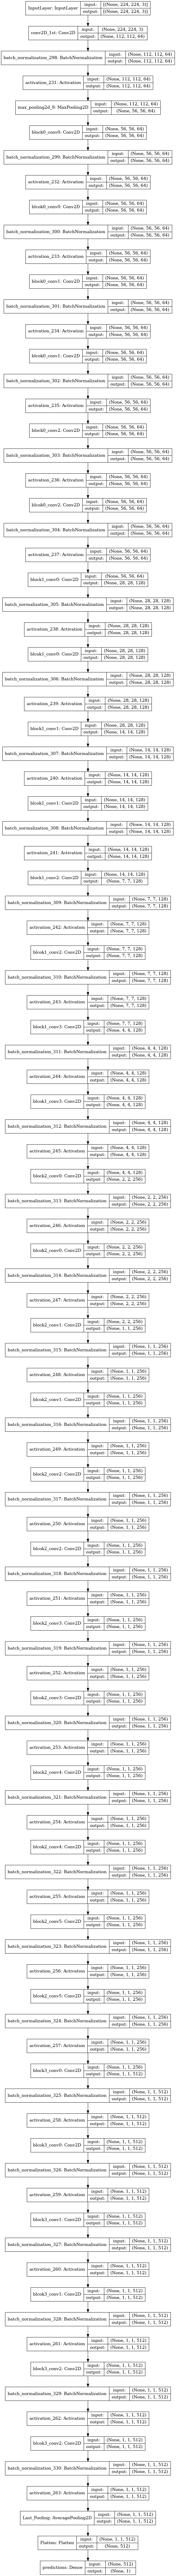

In [34]:
################# plainnet 34 model 생성 ########################
plainnet_34 = build_plainnet(input_shape=(224, 224,3), num_classes = 1, is_50 =False)

plainnet_34.summary()
tf.keras.utils.plot_model(plainnet_34, 'model.png', show_shapes = True)

In [35]:
################# plainnet 34 model 학습 ########################
with tf.device("/device:GPU:0"):
    plainnet_34.compile(
        loss='BinaryCrossentropy',
        optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
        metrics=['accuracy']
    )

    history_plain34 = plainnet_34.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
        validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
        epochs=EPOCH,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

Epoch 1/50


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:182 assert_input_compatibility
        raise ValueError('Missing data for input "%s". '

    ValueError: Missing data for input "InputLayer". You passed a data dictionary with keys ['id', 'image', 'label']. Expected the following keys: ['InputLayer']


In [37]:
# plainnet 50 model 생성
plain_50 = build_plainnet(input_shape=(224, 224,3), num_classes = 1, is_50 = True)

tf.keras.utils.plot_model(plainnet_50, 'model_3.png', show_shapes = True)

ValueError: Operands could not be broadcast together with shapes (14, 14, 512) (28, 28, 512)

In [40]:
# plainnet 50 model 학습
plain_50.compile(
    loss='BinaryCrossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

NameError: name 'plain_50' is not defined

In [41]:
# ResNet 50 model 학습
resnet_50.compile(
    loss='BinaryCrossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy']
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:182 assert_input_compatibility
        raise ValueError('Missing data for input "%s". '

    ValueError: Missing data for input "InputLayer". You passed a data dictionary with keys ['id', 'image', 'label']. Expected the following keys: ['InputLayer']


NameError: name 'history_resnet34' is not defined

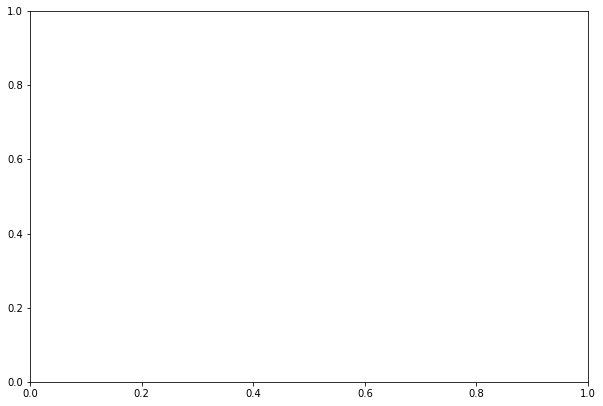

In [42]:
############## plain - 34, 50 시각화 ################
plt.figure(figsize=(10, 15))

plt.subplot(2,1,1)
plt.plot(history_resnet34.history['loss'], 'b')
plt.plot(history_resnet_50.history['loss'], 'r')
plt.title('Model training loss - ResNet')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34', 'ResNet_50'], loc='upper left')
plt.grid()


plt.subplot(2,1,2)
plt.plot(history_resnet34.history['val_accuracy'], 'b')
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.title('Model validation accuracy - ResNet')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34', 'ResNet_50'], loc='upper left')
plt.grid()
plt.subplots_adjust()

plt.show()

* 회고 : 논문 구현에 실패한것 같다..  
첫 번째는 label오류가 난 것을 이해하지 못하겠고(노드의 코드를 그대로 가져왔는데 왜..?)
두 번째는 resnet 모델의 skip connection을 어떻게 구현해야 하는지 몰라 고민하다 시간만 날리고 결국 찾아보았다..